PeopleInHousehold: The number of people in the interviewee's household.

Region: The census region where the interviewee lives.

State: The state where the interviewee lives.

MetroAreaCode: A code that identifies the metropolitan area in which the interviewee lives (missing if the interviewee does not live in a metropolitan area). The mapping from codes to names of metropolitan areas is provided in the file MetroAreaCodes.csv.

Age: The age, in years, of the interviewee. 80 represents people aged 80-84, and 85 represents people aged 85 and higher.

Married: The marriage status of the interviewee.

Sex: The sex of the interviewee.

Education: The maximum level of education obtained by the interviewee.

Race: The race of the interviewee.

Hispanic: Whether the interviewee is of Hispanic ethnicity.

CountryOfBirthCode: A code identifying the country of birth of the interviewee. The mapping from codes to names of countries is provided in the file CountryCodes.csv.

Citizenship: The United States citizenship status of the interviewee.

EmploymentStatus: The status of employment of the interviewee.

Industry: The industry of employment of the interviewee (only available if they are employed).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi



pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("CPSData.csv",low_memory=False)

In [3]:
df

,PeopleInHousehold,Region,State,MetroAreaCode,Age,Married,Sex,Education,Race,Hispanic,CountryOfBirthCode,Citizenship,EmploymentStatus,Industry
0,1,South,Alabama,26620.0,85,Widowed,Female,Associate degree,White,0,57,"Citizen, Native",Retired,NaN
1,3,South,Alabama,13820.0,21,Never Married,Male,High school,Black,0,57,"Citizen, Native",Unemployed,Professional and business services
2,3,South,Alabama,13820.0,37,Never Married,Female,High school,Black,0,57,"Citizen, Native",Disabled,NaN
3,3,South,Alabama,13820.0,18,Never Married,Male,No high school diploma,Black,0,57,"Citizen, Native",Not in Labor Force,NaN
4,3,South,Alabama,26620.0,52,Widowed,Female,Associate degree,White,0,57,"Citizen, Native",Employed,Professional and business services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131297,5,West,Wyoming,NaN,17,Never Married,Male,No high school diploma,White,0,57,"Citizen, Native",Not in Labor Force,NaN
131298,5,West,Wyoming,NaN,37,Divorced,Male,High school,White,0,57,"Citizen, Native",Employed,Mining
131299,3,West,Wyoming,NaN,58,Married,Male,Bachelor's degree,White,0,57,"Citizen, Native",Employed,Financial
131300,3,West,Wyoming,NaN,53,Married,Female,Associate degree,White,0,57,"Citizen, Native",Not in Labor Force,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131302 entries, 0 to 131301
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   PeopleInHousehold   131302 non-null  int64  
 1   Region              131302 non-null  object 
 2   State               131302 non-null  object 
 3   MetroAreaCode       97064 non-null   float64
 4   Age                 131302 non-null  int64  
 5   Married             105964 non-null  object 
 6   Sex                 131302 non-null  object 
 7   Education           105964 non-null  object 
 8   Race                131302 non-null  object 
 9   Hispanic            131302 non-null  int64  
 10  CountryOfBirthCode  131302 non-null  int64  
 11  Citizenship         131302 non-null  object 
 12  EmploymentStatus    105513 non-null  object 
 13  Industry            66242 non-null   object 
dtypes: float64(1), int64(4), object(9)
memory usage: 14.0+ MB


In [5]:
df.describe(include='all')

,PeopleInHousehold,Region,State,MetroAreaCode,Age,Married,Sex,Education,Race,Hispanic,CountryOfBirthCode,Citizenship,EmploymentStatus,Industry
count,131302.000000,131302,131302,97064.000000,131302.000000,105964,131302,105964,131302,131302.000000,131302.000000,131302,105513,66242
unique,NaN,4,51,NaN,NaN,5,2,8,6,NaN,NaN,3,5,14
top,NaN,South,California,NaN,NaN,Married,Female,High school,White,NaN,NaN,"Citizen, Native",Employed,Educational and health services
freq,NaN,41502,11570,NaN,NaN,55509,67481,30906,105921,NaN,NaN,116639,61733,15017
mean,3.284276,NaN,NaN,35074.709264,38.829226,NaN,NaN,NaN,NaN,0.139328,82.684079,NaN,NaN,NaN
std,1.700173,NaN,NaN,16551.637597,22.897130,NaN,NaN,NaN,NaN,0.346289,75.476511,NaN,NaN,NaN
min,1.000000,NaN,NaN,10420.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,57.000000,NaN,NaN,NaN
25%,2.000000,NaN,NaN,21780.000000,19.000000,NaN,NaN,NaN,NaN,0.000000,57.000000,NaN,NaN,NaN
50%,3.000000,NaN,NaN,34740.000000,39.000000,NaN,NaN,NaN,NaN,0.000000,57.000000,NaN,NaN,NaN
75%,4.000000,NaN,NaN,41860.000000,57.000000,NaN,NaN,NaN,NaN,0.000000,57.000000,NaN,NaN,NaN


In [6]:
df.shape

(131302, 14)

### Data Visualization

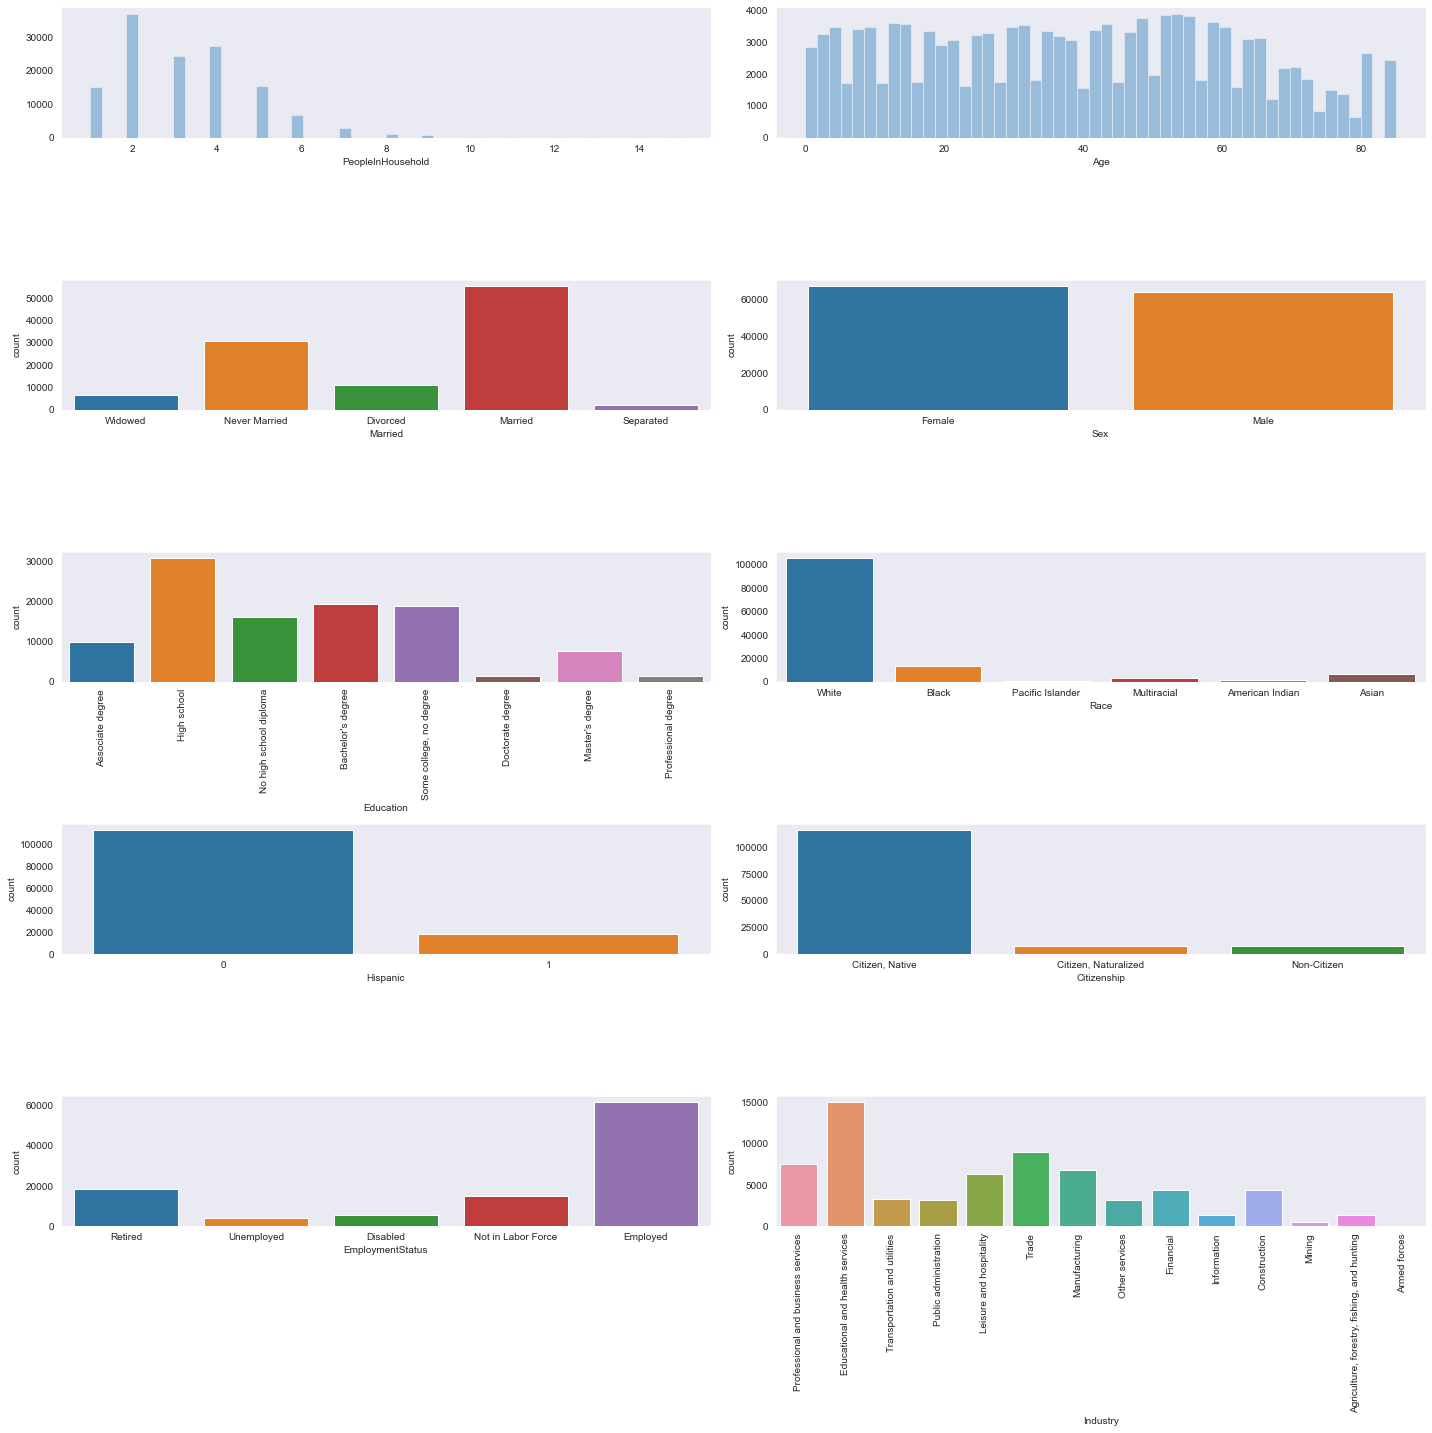

In [7]:
fig = plt.figure(figsize=(20,20))

plt.subplot(5,2,1)
sns.distplot(df.PeopleInHousehold,kde=False)
plt.subplot(5,2,2)
sns.distplot(df.Age,kde=False)
plt.subplot(5,2,3)
sns.countplot(x=df.Married)
plt.subplot(5,2,4)
sns.countplot(x=df.Sex)
plt.subplot(5,2,5)
sns.countplot(x=df.Education)
plt.xticks(rotation=90)
plt.subplot(5,2,6)
sns.countplot(x=df.Race)
plt.subplot(5,2,7)
sns.countplot(x=df.Hispanic)
plt.subplot(5,2,8)
sns.countplot(x=df.Citizenship)
plt.subplot(5,2,9)
sns.countplot(x=df.EmploymentStatus)
plt.subplot(5,2,10)
sns.countplot(x=df.Industry)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

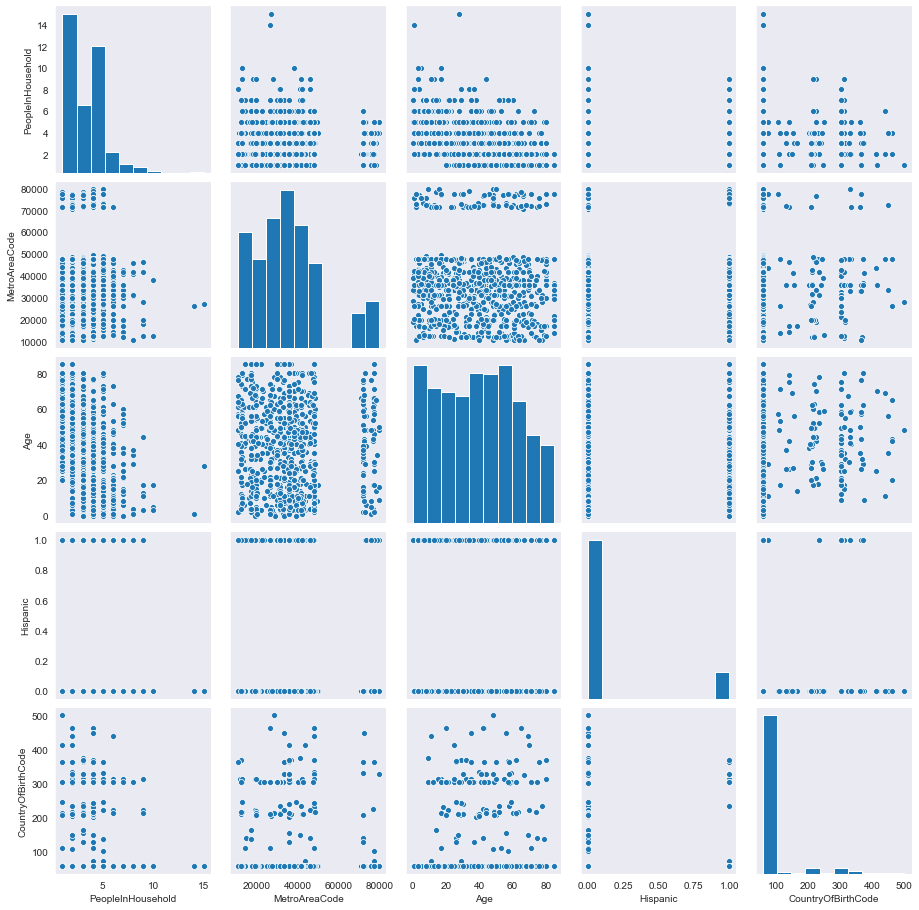

In [8]:
sns.pairplot(df.sample(1000))
plt.show()

#### Remove address and industry

In [9]:
df2 = df[['PeopleInHousehold','Age', 'Married', 'Sex', 'Education', 'Race', 'Hispanic', 'Citizenship', 'EmploymentStatus']]

In [10]:
df2

,PeopleInHousehold,Age,Married,Sex,Education,Race,Hispanic,Citizenship,EmploymentStatus
0,1,85,Widowed,Female,Associate degree,White,0,"Citizen, Native",Retired
1,3,21,Never Married,Male,High school,Black,0,"Citizen, Native",Unemployed
2,3,37,Never Married,Female,High school,Black,0,"Citizen, Native",Disabled
3,3,18,Never Married,Male,No high school diploma,Black,0,"Citizen, Native",Not in Labor Force
4,3,52,Widowed,Female,Associate degree,White,0,"Citizen, Native",Employed
...,...,...,...,...,...,...,...,...,...
131297,5,17,Never Married,Male,No high school diploma,White,0,"Citizen, Native",Not in Labor Force
131298,5,37,Divorced,Male,High school,White,0,"Citizen, Native",Employed
131299,3,58,Married,Male,Bachelor's degree,White,0,"Citizen, Native",Employed
131300,3,53,Married,Female,Associate degree,White,0,"Citizen, Native",Not in Labor Force


In [11]:
df2.corr()

,PeopleInHousehold,Age,Hispanic
PeopleInHousehold,1.000000,-0.494089,0.195947
Age,-0.494089,1.000000,-0.159191
Hispanic,0.195947,-0.159191,1.000000


### Data Preprocessing

In [12]:
df2.isnull().sum()

PeopleInHousehold        0
Age                      0
Married              25338
Sex                      0
Education            25338
Race                     0
Hispanic                 0
Citizenship              0
EmploymentStatus     25789
dtype: int64

In [13]:
df2['Married'].value_counts()

Married          55509
Never Married    30772
Divorced         11151
Widowed           6505
Separated         2027
Name: Married, dtype: int64

In [14]:
df2['Married'].mode()

0    Married
dtype: object

In [15]:
df2['Married'].fillna(value='Separated',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [16]:
df2

,PeopleInHousehold,Age,Married,Sex,Education,Race,Hispanic,Citizenship,EmploymentStatus
0,1,85,Widowed,Female,Associate degree,White,0,"Citizen, Native",Retired
1,3,21,Never Married,Male,High school,Black,0,"Citizen, Native",Unemployed
2,3,37,Never Married,Female,High school,Black,0,"Citizen, Native",Disabled
3,3,18,Never Married,Male,No high school diploma,Black,0,"Citizen, Native",Not in Labor Force
4,3,52,Widowed,Female,Associate degree,White,0,"Citizen, Native",Employed
...,...,...,...,...,...,...,...,...,...
131297,5,17,Never Married,Male,No high school diploma,White,0,"Citizen, Native",Not in Labor Force
131298,5,37,Divorced,Male,High school,White,0,"Citizen, Native",Employed
131299,3,58,Married,Male,Bachelor's degree,White,0,"Citizen, Native",Employed
131300,3,53,Married,Female,Associate degree,White,0,"Citizen, Native",Not in Labor Force


In [17]:
df2['Married'].value_counts()

Married          55509
Never Married    30772
Separated        27365
Divorced         11151
Widowed           6505
Name: Married, dtype: int64

In [18]:
df2['Education'].value_counts()

High school                30906
Bachelor's degree          19443
Some college, no degree    18863
No high school diploma     16095
Associate degree            9913
Master's degree             7816
Doctorate degree            1516
Professional degree         1412
Name: Education, dtype: int64

In [19]:
df2['Education'].fillna(value='Professional degree',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [20]:
df2['Education'].value_counts()

High school                30906
Professional degree        26750
Bachelor's degree          19443
Some college, no degree    18863
No high school diploma     16095
Associate degree            9913
Master's degree             7816
Doctorate degree            1516
Name: Education, dtype: int64

In [21]:
df2['EmploymentStatus'].value_counts()

Employed              61733
Retired               18619
Not in Labor Force    15246
Disabled               5712
Unemployed             4203
Name: EmploymentStatus, dtype: int64

In [22]:
df2['EmploymentStatus'].fillna(value='Unemployed',inplace=True)

In [23]:
df2['EmploymentStatus'].value_counts()

Employed              61733
Unemployed            29992
Retired               18619
Not in Labor Force    15246
Disabled               5712
Name: EmploymentStatus, dtype: int64

In [24]:
df2.isnull().sum()

PeopleInHousehold    0
Age                  0
Married              0
Sex                  0
Education            0
Race                 0
Hispanic             0
Citizenship          0
EmploymentStatus     0
dtype: int64

In [25]:
df2.duplicated(keep='first').sum()

83862

In [26]:
df2[df2.duplicated(keep='first')]

,PeopleInHousehold,Age,Married,Sex,Education,Race,Hispanic,Citizenship,EmploymentStatus
79,2,45,Divorced,Female,Bachelor's degree,Pacific Islander,0,"Citizen, Native",Employed
85,5,10,Separated,Male,Professional degree,White,0,"Citizen, Native",Unemployed
117,3,18,Never Married,Male,No high school diploma,Black,0,"Citizen, Native",Not in Labor Force
148,3,29,Married,Female,Bachelor's degree,White,0,"Citizen, Native",Employed
152,2,24,Never Married,Female,"Some college, no degree",White,0,"Citizen, Native",Employed
...,...,...,...,...,...,...,...,...,...
131296,5,14,Separated,Male,Professional degree,White,0,"Citizen, Native",Unemployed
131297,5,17,Never Married,Male,No high school diploma,White,0,"Citizen, Native",Not in Labor Force
131299,3,58,Married,Male,Bachelor's degree,White,0,"Citizen, Native",Employed
131300,3,53,Married,Female,Associate degree,White,0,"Citizen, Native",Not in Labor Force


In [27]:
df2.shape

(131302, 9)

In [28]:
married = pd.get_dummies(df2['Married'],prefix='Married',drop_first=True)

In [29]:
married

,Married_Married,Married_Never Married,Married_Separated,Married_Widowed
0,0,0,0,1
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,1
...,...,...,...,...
131297,0,1,0,0
131298,0,0,0,0
131299,1,0,0,0
131300,1,0,0,0


In [30]:
sex = pd.get_dummies(df2['Sex'],prefix='Sex',drop_first=True)

In [31]:
sex

,Sex_Male
0,0
1,1
2,0
3,1
4,0
...,...
131297,1
131298,1
131299,1
131300,0


In [32]:
education = pd.get_dummies(df2['Education'],prefix='Education',drop_first=True)

In [33]:
education

,Education_Bachelor's degree,Education_Doctorate degree,Education_High school,Education_Master's degree,Education_No high school diploma,Education_Professional degree,"Education_Some college, no degree"
0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
131297,0,0,0,0,1,0,0
131298,0,0,1,0,0,0,0
131299,1,0,0,0,0,0,0
131300,0,0,0,0,0,0,0


In [34]:
race = pd.get_dummies(df2['Race'],prefix='Race',drop_first=True)

In [35]:
race

,Race_Asian,Race_Black,Race_Multiracial,Race_Pacific Islander,Race_White
0,0,0,0,0,1
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
131297,0,0,0,0,1
131298,0,0,0,0,1
131299,0,0,0,0,1
131300,0,0,0,0,1


In [36]:
df2['Hispanic'].value_counts()

0    113008
1     18294
Name: Hispanic, dtype: int64

In [37]:
citizen = pd.get_dummies(df2['Citizenship'],prefix='Citizen',drop_first=True)

In [38]:
citizen

,"Citizen_Citizen, Naturalized",Citizen_Non-Citizen
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
131297,0,0
131298,0,0
131299,0,0
131300,0,0


In [39]:
df2

,PeopleInHousehold,Age,Married,Sex,Education,Race,Hispanic,Citizenship,EmploymentStatus
0,1,85,Widowed,Female,Associate degree,White,0,"Citizen, Native",Retired
1,3,21,Never Married,Male,High school,Black,0,"Citizen, Native",Unemployed
2,3,37,Never Married,Female,High school,Black,0,"Citizen, Native",Disabled
3,3,18,Never Married,Male,No high school diploma,Black,0,"Citizen, Native",Not in Labor Force
4,3,52,Widowed,Female,Associate degree,White,0,"Citizen, Native",Employed
...,...,...,...,...,...,...,...,...,...
131297,5,17,Never Married,Male,No high school diploma,White,0,"Citizen, Native",Not in Labor Force
131298,5,37,Divorced,Male,High school,White,0,"Citizen, Native",Employed
131299,3,58,Married,Male,Bachelor's degree,White,0,"Citizen, Native",Employed
131300,3,53,Married,Female,Associate degree,White,0,"Citizen, Native",Not in Labor Force


In [40]:
df2.drop(['Married', 'Sex' ,'Education', 'Race', 'Citizenship'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [41]:
df2

,PeopleInHousehold,Age,Hispanic,EmploymentStatus
0,1,85,0,Retired
1,3,21,0,Unemployed
2,3,37,0,Disabled
3,3,18,0,Not in Labor Force
4,3,52,0,Employed
...,...,...,...,...
131297,5,17,0,Not in Labor Force
131298,5,37,0,Employed
131299,3,58,0,Employed
131300,3,53,0,Not in Labor Force


In [42]:
df3 = pd.concat([married,sex,education,race,citizen,df2],axis=1)

In [43]:
df3

,Married_Married,Married_Never Married,Married_Separated,Married_Widowed,Sex_Male,Education_Bachelor's degree,Education_Doctorate degree,Education_High school,Education_Master's degree,Education_No high school diploma,Education_Professional degree,"Education_Some college, no degree",Race_Asian,Race_Black,Race_Multiracial,Race_Pacific Islander,Race_White,"Citizen_Citizen, Naturalized",Citizen_Non-Citizen,PeopleInHousehold,Age,Hispanic,EmploymentStatus
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,85,0,Retired
1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,21,0,Unemployed
2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,37,0,Disabled
3,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,18,0,Not in Labor Force
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,52,0,Employed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131297,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,5,17,0,Not in Labor Force
131298,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,5,37,0,Employed
131299,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,58,0,Employed
131300,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,53,0,Not in Labor Force


In [44]:
encoder = LabelEncoder()

In [45]:
df3['EmploymentStatus'] = encoder.fit_transform(df3['EmploymentStatus'])

In [46]:
df3.head(10)

,Married_Married,Married_Never Married,Married_Separated,Married_Widowed,Sex_Male,Education_Bachelor's degree,Education_Doctorate degree,Education_High school,Education_Master's degree,Education_No high school diploma,Education_Professional degree,"Education_Some college, no degree",Race_Asian,Race_Black,Race_Multiracial,Race_Pacific Islander,Race_White,"Citizen_Citizen, Naturalized",Citizen_Non-Citizen,PeopleInHousehold,Age,Hispanic,EmploymentStatus
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,85,0,3
1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,21,0,4
2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,37,0,0
3,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,18,0,2
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,52,0,1
5,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,24,0,1
6,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3,26,0,1
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,71,0,1
8,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,43,0,2
9,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,52,0,1


## 0 = Disabled, 1 = Employed, 2 = Not in Labor Force, 3 = Retired, 4 = Unemployed

### Model Training

In [47]:
X = df3.iloc[:,0:22]
y = df3.iloc[:,22]

In [48]:
X.values, y.values

(array([[ 0,  0,  0, ...,  1, 85,  0],
        [ 0,  1,  0, ...,  3, 21,  0],
        [ 0,  1,  0, ...,  3, 37,  0],
        ...,
        [ 1,  0,  0, ...,  3, 58,  0],
        [ 1,  0,  0, ...,  3, 53,  0],
        [ 0,  0,  1, ...,  3, 14,  0]], dtype=int64),
 array([3, 4, 0, ..., 1, 2, 4]))

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [50]:
X_train.shape, X_test.shape

((105041, 22), (26261, 22))

In [51]:
xgb = XGBClassifier(random_state=0, n_estimators=400, objective='multi:softmax')

In [52]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='merror',early_stopping_rounds=20)

[0]	validation_0-merror:0.224706
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.224058
[2]	validation_0-merror:0.224058
[3]	validation_0-merror:0.224477
[4]	validation_0-merror:0.224477
[5]	validation_0-merror:0.222459
[6]	validation_0-merror:0.222573
[7]	validation_0-merror:0.222573
[8]	validation_0-merror:0.222269
[9]	validation_0-merror:0.222269
[10]	validation_0-merror:0.222269
[11]	validation_0-merror:0.222269
[12]	validation_0-merror:0.222231
[13]	validation_0-merror:0.222307
[14]	validation_0-merror:0.222307
[15]	validation_0-merror:0.222231
[16]	validation_0-merror:0.22204
[17]	validation_0-merror:0.222193
[18]	validation_0-merror:0.222078
[19]	validation_0-merror:0.222383
[20]	validation_0-merror:0.222307
[21]	validation_0-merror:0.222193
[22]	validation_0-merror:0.223221
[23]	validation_0-merror:0.223221
[24]	validation_0-merror:0.223183
[25]	validation_0-merror:0.223221
[26]	validation_0-merror:0.223145
[27]	validation_0-merror:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [53]:
y_pred = xgb.predict(X_test)

In [54]:
y_pred

array([4, 1, 3, ..., 1, 1, 3])

### Model Evaluation

In [55]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1130
           1       0.72      0.92      0.81     12453
           2       0.76      0.34      0.47      3089
           3       0.73      0.80      0.76      3697
           4       1.00      0.85      0.92      5892

    accuracy                           0.78     26261
   macro avg       0.64      0.58      0.59     26261
weighted avg       0.76      0.78      0.75     26261



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


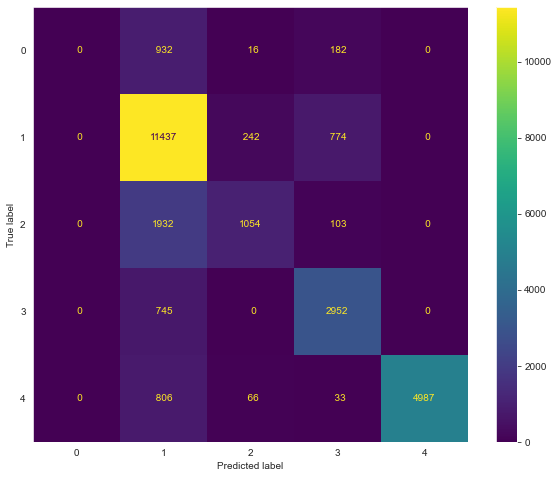

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(xgb,X_test,y_test,ax=ax,values_format='4g')
plt.show()